# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.342402,True,5.479341
1,0.244488,False,1.817311
2,-0.770680,False,0.168327
3,-0.480814,False,-0.313176
4,1.055901,False,0.460178
...,...,...,...
995,0.999518,True,4.377403
996,2.024107,True,7.888144
997,-0.470624,False,-1.263625
998,0.309420,False,-1.626010


<AxesSubplot: xlabel='v0'>

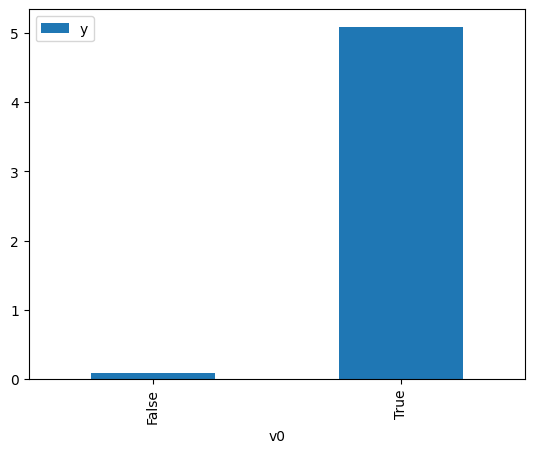

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

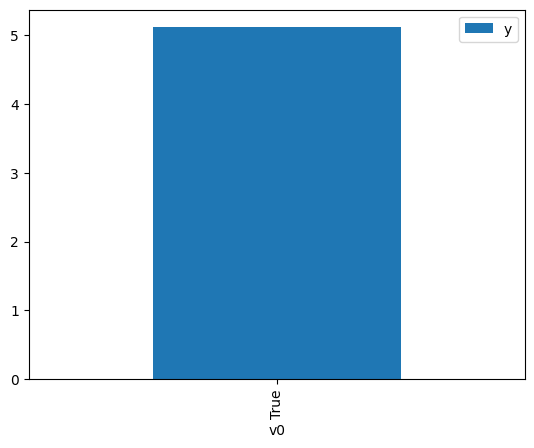

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.374190,False,-0.785740,0.501283,1.994881
1,0.541826,False,0.652970,0.456634,2.189936
2,-0.487385,False,-0.242180,0.506813,1.973113
3,1.917741,False,1.240632,0.391070,2.557084
4,0.415258,False,-1.624770,0.462778,2.160861
...,...,...,...,...,...
995,0.002750,False,0.860693,0.482872,2.070943
996,2.200041,False,2.039446,0.378013,2.645409
997,0.613383,False,-1.528699,0.453167,2.206694
998,0.226815,False,-0.330047,0.471947,2.118884


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.802699,True,5.918935,0.555986,1.798608
1,2.486522,True,7.592470,0.635059,1.574658
2,0.902110,True,6.817500,0.560777,1.783241
3,0.948895,True,5.425099,0.563028,1.776112
4,-0.183308,True,5.391861,0.508043,1.968337
...,...,...,...,...,...
995,0.574892,True,4.852948,0.544969,1.834968
996,1.425338,True,5.074947,0.585787,1.707104
997,2.003776,True,4.436617,0.612926,1.631517
998,-0.414010,True,5.670990,0.496771,2.012998


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7456.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):                        0.00
Time:                        16:32:44   Log-Likelihood:                         -1407.1
No. Observations:                1000   AIC:                                      2818.
Df Residuals:                     998   BIC:                                      2828.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6938      0.031     22.464      0.000       0.633       0.754
x2             5.0179      0.044    114.383      0.000       4.932       5.104
==============================================================================
Omnibus:                        1.945   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.948
Skew:                           0.017   Prob(JB):                        0.377
Kurtosis:                       3.214   Cond. No.                         1.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""